In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import skimage

# need the following to successfully run. 
# Otherwise there will be cuDNN error in training 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()

dir = "tf_logs/20190423-222308/model"

In [2]:
model = tf.saved_model.load(dir)

AttributeError: '_UserObject' object has no attribute '_create_or_restore_slot_variable'

In [3]:
weights_dir = "tf_logs/20190423-222308/model_weights.ckpt"

mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224, 3), include_top=False)
# add fc layers after mobilenet for transfer learning
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = tf.nn.relu),
    tf.keras.layers.Dense(23, activation=tf.nn.softmax)])
model.load_weights(weights_dir)

In [4]:
def img_preprocessing(path):
    image = skimage.io.imread(path)
    # convert grayscale images to rgb
    if image.ndim ==2:
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    H, W = image.shape[0], image.shape[1]
    if H>W:
        H_new, W_new = 224, round(W/H*224)
    else:
        H_new, W_new = round(H/W*224), 224 
    image = skimage.transform.resize(image, output_shape=(H_new, W_new), preserve_range=True)
    # zero-pad the image
    temp = np.zeros((224,224,3))
    temp[:image.shape[0], :image.shape[1], :] = image
    image = temp
    image = image/255   # to range [0, 1]
    image = 2*image-1    # to range[-1,1]
    return image

In [5]:
test_image_path = "downloaded_data/air_jordan_8/air_jordan_8_7.jpg"
image = img_preprocessing(test_image_path)

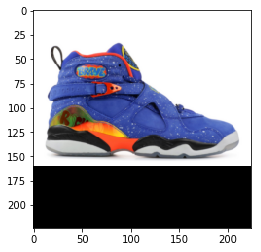

In [6]:
plt.imshow(0.5*(image+1))

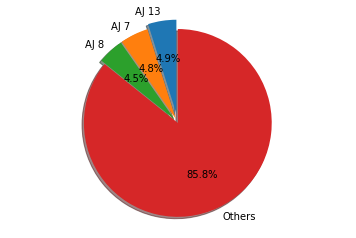

In [7]:
def logits_to_probs(logits):
    probs = np.exp(logits) / np.exp(logits).sum()
    probs = probs.reshape(probs.shape[1],)
    return probs

def plot_probs(probs):
    indices = np.argsort(probs)[::-1]
    probs = np.sort(probs)[::-1]
    top_k = 3
    probs_temp = np.append(probs[:top_k],np.sum(probs[top_k:]))
    keys = ['AJ '+str(i+1) for i in indices[:top_k]] + ['Others']
    explode = (0.1, 0.05, 0.05, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(probs_temp, explode=explode, labels=keys, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


logits = model.predict(np.expand_dims(image, axis=0))
probs = logits_to_probs(logits)
plot_probs(probs)